<h1 align= "center">Sentiment Analysis on Yelp Reviews</h1>

In [3]:
# libraries used in this project
import os, re, string, warnings, json, pickle

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# download nltk data
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

True

In [5]:
# configs
DATASET_NAME = "Yelp/yelp_review_full"
SUBSET_TRAIN_N = 200_000
SUBSET_TEST_N = 50_000
NGRAMS = (1, 2)
MAX_FEATS = 300_000
OUT_DIR = "model"
CLASS_NAMES = ["negative", "neutral", "positive"]
os.makedirs(OUT_DIR, exist_ok=True)

In [6]:
# load dataset
ds = load_dataset(DATASET_NAME)
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()
print("sizes:", len(train_df), len(test_df))

sizes: 650000 50000


In [7]:
train_df["stars"] = train_df["label"].astype(int) + 1
test_df["stars"] = test_df["label"].astype(int) + 1
if SUBSET_TRAIN_N and len(train_df) > SUBSET_TRAIN_N:
    idx = np.random.RandomState(RANDOM_STATE).choice(
        len(train_df), SUBSET_TRAIN_N, replace=False
    )
    train_df = train_df.iloc[idx].reset_index(drop=True)
if SUBSET_TEST_N and len(test_df) > SUBSET_TEST_N:
    idx = np.random.RandomState(RANDOM_STATE).choice(
        len(test_df), SUBSET_TEST_N, replace=False
    )
    test_df = test_df.iloc[idx].reset_index(drop=True)

train_df.head()

,label,text,stars
0,0,"First of all i'm not a big fan of buffet, i tr...",1
1,1,Thanks Yelp. I was looking for the words to de...,2
2,2,Service was so-so. They were receiving a deliv...,3
3,2,Stamoolis Brothers is one of the Strip Distric...,3
4,0,I want to give a 2 stars because the service s...,1


In [8]:
# stars distribution table
star_counts = train_df["stars"].value_counts().sort_index()
pd.DataFrame({"stars": star_counts.index, "count": star_counts.values})

,stars,count
0,1,40166
1,2,40093
2,3,39939
3,4,40101
4,5,39701


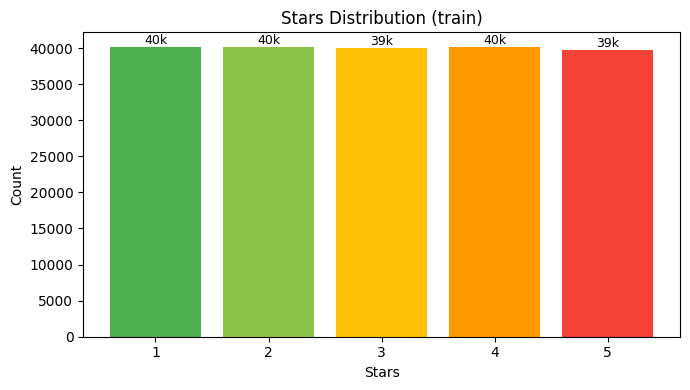

In [9]:
# stars distribution plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(
    star_counts.index.astype(str),
    star_counts.values,
    color=["#4CAF50", "#8BC34A", "#FFC107", "#FF9800", "#F44336"],
)
ax.set_title("Stars Distribution (train)")
ax.set_xlabel("Stars")
ax.set_ylabel("Count")
for i, v in enumerate(star_counts.values):
    ax.text(i, v, f"{v//1000}k", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

In [10]:
# build 3-class target: <=2->0(neg), ==3->1(neu), >=4->2(pos)
train_df["y3"] = np.where(
    train_df["stars"] <= 2, 0, np.where(train_df["stars"] == 3, 1, 2)
)
test_df["y3"] = np.where(
    test_df["stars"] <= 2, 0, np.where(test_df["stars"] == 3, 1, 2)
)

cls_counts = train_df["y3"].value_counts().sort_index()
pd.DataFrame({"class": ["negative", "neutral", "positive"], "count": cls_counts.values})

,class,count
0,negative,80259
1,neutral,39939
2,positive,79802


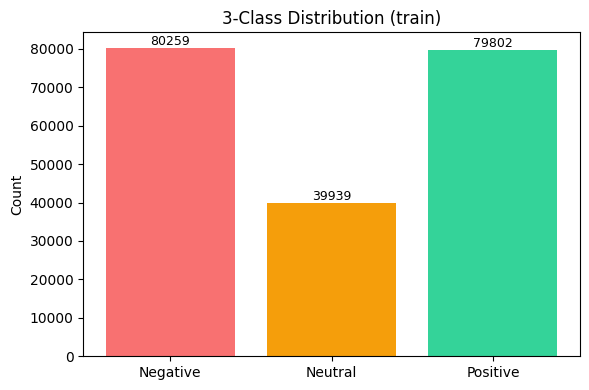

In [11]:
# 3-class distribution plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    ["Negative", "Neutral", "Positive"],
    cls_counts.values,
    color=["#F87171", "#F59E0B", "#34D399"],
)
ax.set_title("3-Class Distribution (train)")
ax.set_ylabel("Count")
for i, v in enumerate(cls_counts.values):
    ax.text(i, v, str(v), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

In [12]:
# cleaning
STOP = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()
PUNCT = str.maketrans("", "", string.punctuation)


def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(PUNCT)
    toks = word_tokenize(s)
    toks = [w for w in toks if w.isalpha() and w not in STOP]
    toks = [LEMM.lemmatize(w) for w in toks]
    return " ".join(toks)


train_df["_clean"] = train_df["text"].astype(str).apply(clean_text)
test_df["_clean"] = test_df["text"].astype(str).apply(clean_text)
train_df.head(3)

,label,text,stars,y3,_clean
0,0,"First of all i'm not a big fan of buffet, i tr...",1,0,first im big fan buffet tried got credit stayi...
1,1,Thanks Yelp. I was looking for the words to de...,2,0,thanks yelp looking word describe place meh se...
2,2,Service was so-so. They were receiving a deliv...,3,1,service soso receiving delivery might food hot...


In [13]:
# length stats table
train_df["_len"] = train_df["_clean"].str.len()
train_df["_words"] = train_df["_clean"].str.split().apply(len)
pd.concat(
    {
        "len_chars": train_df["_len"].describe(),
        "len_words": train_df["_words"].describe(),
    },
    axis=1,
)

,len_chars,len_words
count,200000.000000,200000.000000
mean,445.136090,67.862840
std,402.137965,60.577458
min,0.000000,0.000000
25%,175.000000,27.000000
50%,326.000000,50.000000
75%,581.000000,89.000000
max,3833.000000,716.000000


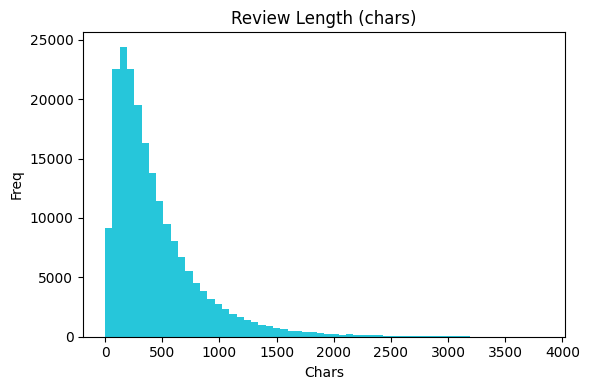

In [14]:
# histogram: char length
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(train_df["_len"], bins=60, color="#00BCD4", alpha=0.85)
ax.set_title("Review Length (chars)")
ax.set_xlabel("Chars")
ax.set_ylabel("Freq")
plt.tight_layout()
plt.show()

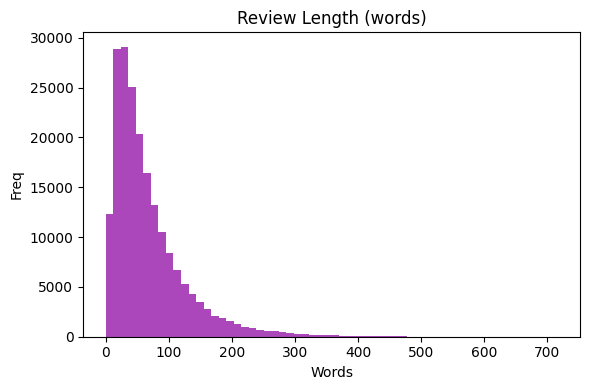

In [15]:
# histogram: word length
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(train_df["_words"], bins=60, color="#9C27B0", alpha=0.85)
ax.set_title("Review Length (words)")
ax.set_xlabel("Words")
ax.set_ylabel("Freq")
plt.tight_layout()
plt.show()

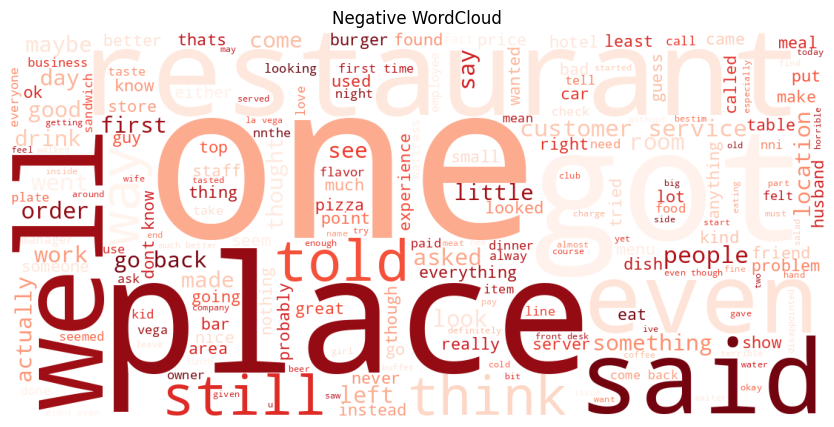

In [16]:
# wordcloud: negative
txt = " ".join(train_df.loc[train_df["y3"] == 0, "_clean"].tolist())
wc = WordCloud(
    width=1100,
    height=520,
    stopwords=STOPWORDS,
    background_color="white",
    colormap="Reds",
).generate(txt if txt else "none")
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis("off")
plt.title("Negative WordCloud")
plt.show()

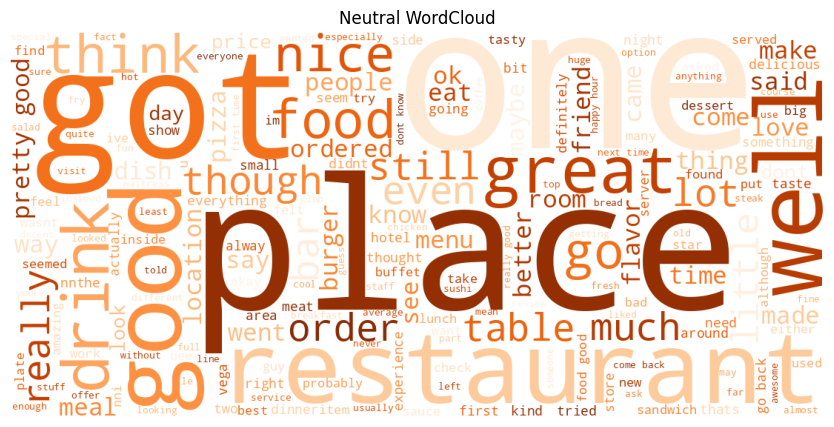

In [17]:
# wordcloud: neutral
txt = " ".join(train_df.loc[train_df["y3"] == 1, "_clean"].tolist())
wc = WordCloud(
    width=1100,
    height=520,
    stopwords=STOPWORDS,
    background_color="white",
    colormap="Oranges",
).generate(txt if txt else "none")
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis("off")
plt.title("Neutral WordCloud")
plt.show()

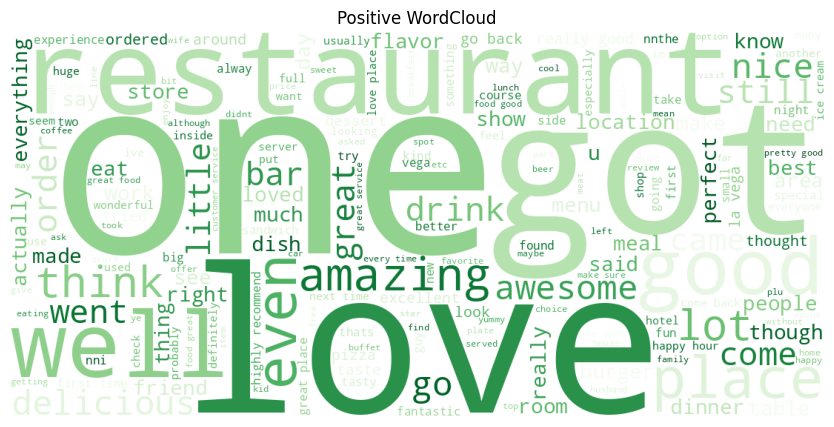

In [18]:
# wordcloud: positive
txt = " ".join(train_df.loc[train_df["y3"] == 2, "_clean"].tolist())
wc = WordCloud(
    width=1100,
    height=520,
    stopwords=STOPWORDS,
    background_color="white",
    colormap="Greens",
).generate(txt if txt else "none")
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis("off")
plt.title("Positive WordCloud")
plt.show()

In [19]:
# top ngrams function
def top_ngrams(texts, n=20, ngram_range=(1, 1)):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(texts)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(-sums)[:n]
    return pd.DataFrame({"term": terms[order], "count": sums[order]})

In [20]:
# top unigrams tables
top_uni_neg = top_ngrams(train_df.loc[train_df["y3"] == 0, "_clean"], 20, (1, 1))
top_uni_neu = top_ngrams(train_df.loc[train_df["y3"] == 1, "_clean"], 20, (1, 1))
top_uni_pos = top_ngrams(train_df.loc[train_df["y3"] == 2, "_clean"], 20, (1, 1))
top_uni_neg

,term,count
0,food,54274
1,place,51856
2,time,44445
3,like,44121
4,good,37762
5,service,35813
6,dont,26181
7,didnt,24791
8,really,24394
9,got,24079


In [21]:
# top unigrams (neutral)
top_uni_neu

,term,count
0,good,33076
1,place,26728
2,food,26358
3,like,22394
4,time,18095
5,really,15888
6,service,13588
7,great,13569
8,pretty,11382
9,nice,11081


In [22]:
# top unigrams (positive)
top_uni_pos

,term,count
0,place,49230
1,good,45847
2,great,43908
3,food,39122
4,time,32314
5,like,30964
6,really,23850
7,service,23302
8,love,18631
9,best,18119


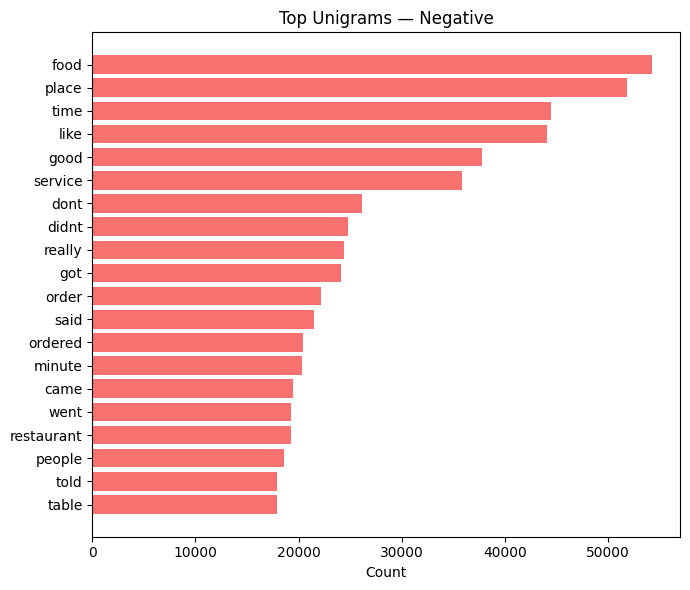

In [23]:
# plot: top unigrams negative
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_uni_neg))
ax.barh(y, top_uni_neg["count"], color="#F87171")
ax.set_yticks(y)
ax.set_yticklabels(top_uni_neg["term"])
ax.invert_yaxis()
ax.set_title("Top Unigrams — Negative")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

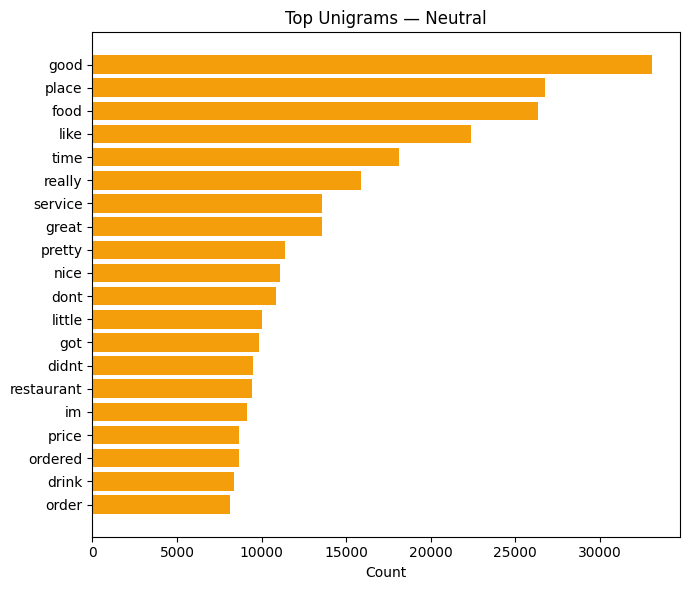

In [24]:
# plot: top unigrams neutral
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_uni_neu))
ax.barh(y, top_uni_neu["count"], color="#F59E0B")
ax.set_yticks(y)
ax.set_yticklabels(top_uni_neu["term"])
ax.invert_yaxis()
ax.set_title("Top Unigrams — Neutral")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

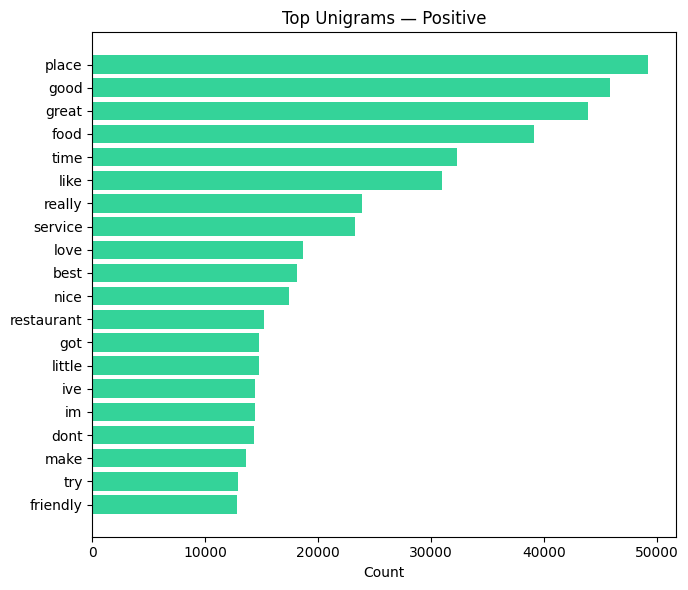

In [25]:
# plot: top unigrams positive
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_uni_pos))
ax.barh(y, top_uni_pos["count"], color="#34D399")
ax.set_yticks(y)
ax.set_yticklabels(top_uni_pos["term"])
ax.invert_yaxis()
ax.set_title("Top Unigrams — Positive")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

In [26]:
# top bigrams tables
top_bi_neg = top_ngrams(train_df.loc[train_df["y3"] == 0, "_clean"], 20, (2, 2))
top_bi_neu = top_ngrams(train_df.loc[train_df["y3"] == 1, "_clean"], 20, (2, 2))
top_bi_pos = top_ngrams(train_df.loc[train_df["y3"] == 2, "_clean"], 20, (2, 2))
top_bi_neg

,term,count
0,customer service,6214
1,dont know,3537
2,tasted like,2937
3,la vega,2346
4,looked like,2136
5,food good,2131
6,pretty good,2104
7,look like,1979
8,minute later,1971
9,dont think,1957


In [27]:
# top bigrams (neutral)
top_bi_neu

,term,count
0,pretty good,3066
1,food good,2087
2,really good,1669
3,happy hour,1463
4,dont know,1357
5,im sure,1237
6,feel like,1202
7,la vega,1176
8,ice cream,1046
9,dont think,1017


In [28]:
# top bigrams (positive)
top_bi_pos

,term,count
0,really good,3250
1,la vega,3089
2,great place,2661
3,highly recommend,2625
4,happy hour,2555
5,love place,2320
6,pretty good,2275
7,ice cream,2274
8,great food,2162
9,great service,2071


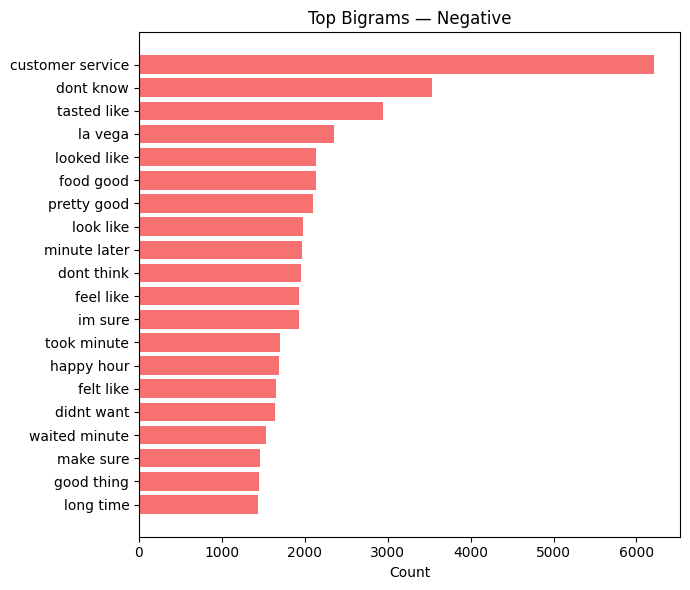

In [29]:
# plot: top bigrams negative
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_bi_neg))
ax.barh(y, top_bi_neg["count"], color="#F87171")
ax.set_yticks(y)
ax.set_yticklabels(top_bi_neg["term"])
ax.invert_yaxis()
ax.set_title("Top Bigrams — Negative")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

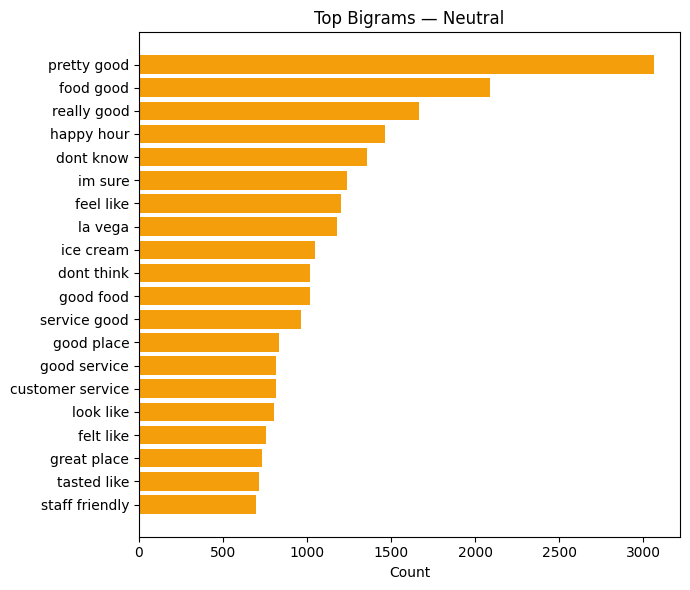

In [30]:
# plot: top bigrams neutral
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_bi_neu))
ax.barh(y, top_bi_neu["count"], color="#F59E0B")
ax.set_yticks(y)
ax.set_yticklabels(top_bi_neu["term"])
ax.invert_yaxis()
ax.set_title("Top Bigrams — Neutral")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

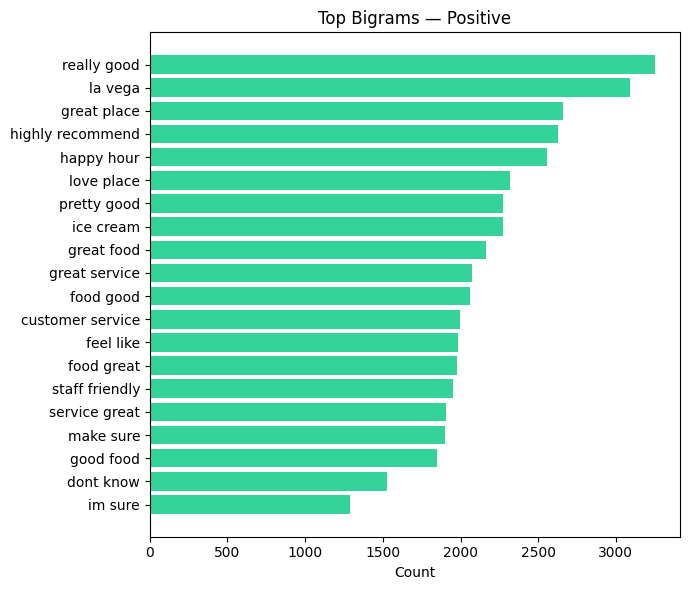

In [31]:
# plot: top bigrams positive
fig, ax = plt.subplots(figsize=(7, 6))
y = np.arange(len(top_bi_pos))
ax.barh(y, top_bi_pos["count"], color="#34D399")
ax.set_yticks(y)
ax.set_yticklabels(top_bi_pos["term"])
ax.invert_yaxis()
ax.set_title("Top Bigrams — Positive")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

In [32]:
# split & vectorize
X_train, X_val, y_train, y_val = train_test_split(
    train_df["_clean"],
    train_df["y3"],
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=train_df["y3"],
)
tfidf = TfidfVectorizer(
    max_features=MAX_FEATS, ngram_range=NGRAMS, min_df=2, max_df=0.99
)
Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_val)

In [ ]:
# models {}
# svc = LinearSVC(random_state=RANDOM_STATE)
# svc_cal = CalibratedClassifierCV(svc, method="sigmoid", cv=3)
# svc_cal.fit(Xtr, y_train)
# models["CalibratedSVC"] = svc_cal

In [33]:
# train models (multiclass)
models = {}

lr = LogisticRegression(
    max_iter=500,
    solver="lbfgs",
    multi_class="multinomial",
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
lr.fit(Xtr, y_train)
models["LogRegMulti"] = lr

svc = LinearSVC(random_state=RANDOM_STATE)
svc_cal = CalibratedClassifierCV(svc, method="sigmoid", cv=3)
svc_cal.fit(Xtr, y_train)
models["CalibratedSVC"] = svc_cal

nb = MultinomialNB()
nb.fit(Xtr, y_train)
models["MultinomialNB"] = nb

sgd = SGDClassifier(
    loss="log_loss",
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
sgd.fit(Xtr, y_train)
models["SGDLog"] = sgd

list(models.keys())

['LogRegMulti', 'CalibratedSVC', 'MultinomialNB', 'SGDLog']

In [34]:
# evaluate models
def eval_model(name, m, Xv, yv):
    pred = m.predict(Xv)
    acc = accuracy_score(yv, pred)
    f1m = f1_score(yv, pred, average="macro")
    f1w = f1_score(yv, pred, average="weighted")
    print(f"== {name} ==")
    print({"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w})
    print(classification_report(yv, pred, target_names=CLASS_NAMES, digits=4))
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}, pred


results = {}
preds = {}
for name, m in models.items():
    met, p = eval_model(name, m, Xva, y_val)
    results[name] = met
    preds[name] = p

pd.DataFrame(results).T.sort_values("f1_macro", ascending=False)

== LogRegMulti ==
{'accuracy': 0.7698333333333334, 'f1_macro': 0.734691060109201, 'f1_weighted': 0.774923695954988}
              precision    recall  f1-score   support

    negative     0.8564    0.8131    0.8342     12039
     neutral     0.4953    0.5792    0.5340      5991
    positive     0.8506    0.8217    0.8359     11970

    accuracy                         0.7698     30000
   macro avg     0.7341    0.7380    0.7347     30000
weighted avg     0.7820    0.7698    0.7749     30000

== CalibratedSVC ==
{'accuracy': 0.7788, 'f1_macro': 0.7015950163794488, 'f1_weighted': 0.7596260186441881}
              precision    recall  f1-score   support

    negative     0.8063    0.8895    0.8459     12039
     neutral     0.5754    0.3210    0.4121      5991
    positive     0.8023    0.8966    0.8468     11970

    accuracy                         0.7788     30000
   macro avg     0.7280    0.7024    0.7016     30000
weighted avg     0.7586    0.7788    0.7596     30000

== Multinomial

,accuracy,f1_macro,f1_weighted
LogRegMulti,0.769833,0.734691,0.774924
CalibratedSVC,0.778800,0.701595,0.759626
SGDLog,0.746767,0.689903,0.738120
MultinomialNB,0.729133,0.555581,0.656662


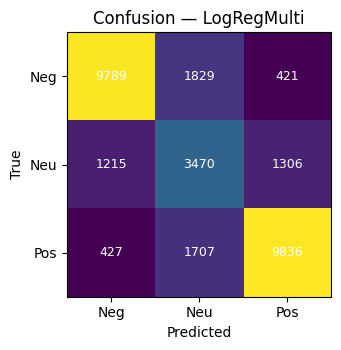

In [35]:
# confusion matrix: LogRegMulti
from itertools import product

cm = confusion_matrix(y_val, preds["LogRegMulti"])
fig, ax = plt.subplots(figsize=(4.2, 3.6))
im = ax.imshow(cm, cmap="viridis")
ax.set_title("Confusion — LogRegMulti")
ax.set_xlabel("Predicted")
# ax.set_ylabel("True")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Neg", "Neu", "Pos"])
ax.set_yticklabels(["Neg", "Neu", "Pos"])
for i, j in product(range(3), range(3)):
    ax.text(j, i, cm[i, j], ha="center", va="center", color="white", fontsize=9)
plt.tight_layout()
plt.show()

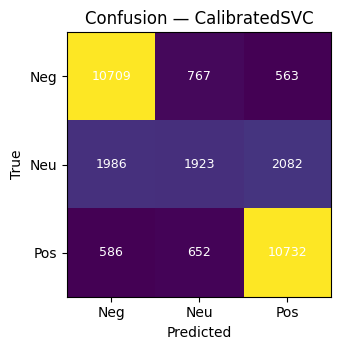

In [36]:
# confusion matrix: CalibratedSVC
from itertools import product

cm = confusion_matrix(y_val, preds["CalibratedSVC"])
fig, ax = plt.subplots(figsize=(4.2, 3.6))
im = ax.imshow(cm, cmap="viridis")
ax.set_title("Confusion — CalibratedSVC")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Neg", "Neu", "Pos"])
ax.set_yticklabels(["Neg", "Neu", "Pos"])
for i, j in product(range(3), range(3)):
    ax.text(j, i, cm[i, j], ha="center", va="center", color="white", fontsize=9)
plt.tight_layout()
plt.show()

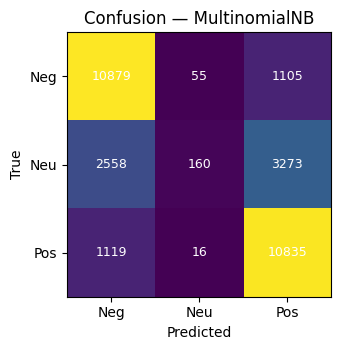

In [37]:
# confusion matrix: MultinomialNB
from itertools import product

cm = confusion_matrix(y_val, preds["MultinomialNB"])
fig, ax = plt.subplots(figsize=(4.2, 3.6))
im = ax.imshow(cm, cmap="viridis")
ax.set_title("Confusion — MultinomialNB")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Neg", "Neu", "Pos"])
ax.set_yticklabels(["Neg", "Neu", "Pos"])
for i, j in product(range(3), range(3)):
    ax.text(j, i, cm[i, j], ha="center", va="center", color="white", fontsize=9)
plt.tight_layout()
plt.show()

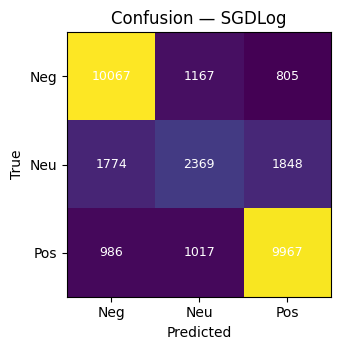

In [38]:
# confusion matrix: SGDLog
from itertools import product

cm = confusion_matrix(y_val, preds["SGDLog"])
fig, ax = plt.subplots(figsize=(4.2, 3.6))
im = ax.imshow(cm, cmap="viridis")
ax.set_title("Confusion — SGDLog")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Neg", "Neu", "Pos"])
ax.set_yticklabels(["Neg", "Neu", "Pos"])
for i, j in product(range(3), range(3)):
    ax.text(j, i, cm[i, j], ha="center", va="center", color="white", fontsize=9)
plt.tight_layout()
plt.show()

In [39]:
# export best by macro-F1
best_name = max(results.items(), key=lambda kv: kv[1]["f1_macro"])[0]
best_model = models[best_name]
artifact = {
    "vectorizer": tfidf,
    "classifier": best_model,
    "class_names": CLASS_NAMES,
    "dataset": DATASET_NAME,
}
import joblib

joblib.dump(artifact, f"{OUT_DIR}/sentiment_analysis_model.joblib")
with open(f"{OUT_DIR}/sentiment_analysis_model.pkl", "wb") as f:
    pickle.dump(artifact, f)
print("Saved:", f"{OUT_DIR}/sentiment_analysis_model.joblib", "| Best:", best_name)

Saved: model/sentiment_analysis_model.joblib | Best: LogRegMulti


In [43]:
def infer(txt, art):
    # clean text like training
    s = str(txt).lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    toks = word_tokenize(s)
    toks = [w for w in toks if w.isalpha() and w not in stopwords.words("english")]
    toks = [WordNetLemmatizer().lemmatize(w) for w in toks]
    clean = " ".join(toks)
    X = art["vectorizer"].transform([clean])
    clf = art["classifier"]
    names = art.get("class_names", ["negative", "neutral", "positive"])
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X)[0]
        if hasattr(clf, "classes_"):
            order = np.argsort(clf.classes_)
            probs = probs[order]
    elif hasattr(clf, "decision_function"):
        scr = clf.decision_function(X)
        scr = np.asarray(scr).ravel()
        scr = scr - scr.max()
        exps = np.exp(scr)
        probs = exps / exps.sum()
    else:
        idx = int(clf.predict(X)[0])
        probs = np.zeros(len(names))
        probs[idx] = 1.0

    idx = int(np.argmax(probs))
    return names[idx], {n: float(p) for n, p in zip(names, probs)}


art = joblib.load(f"{OUT_DIR}/sentiment_analysis_model.joblib")

# test prediction
lbl, proba = infer("Food was okay service average overall fine", art)
print("Label:", lbl, "| Probabilities:", proba)

Label: neutral | Probabilities: {'negative': 0.14495670542243358, 'neutral': 0.8538684824590923, 'positive': 0.0011748121184742188}
